# Problem sugestion with MAB algorithms

We are using a simple MAB algorithm to select problems to competitive programming competitors. In this work we first introduce the base case.

First we start with the Epsilon-Greedy algorithm.

## The data

The algorithm will be trainning using the data from the URI Onlide Judge. We solve around of 200k solutions.
The solutions is a list of tuples composed by `(problem_id, user_id, date)`.

At first we will read the data and sort by date.

In [310]:
import random, math
from itertools import groupby
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt

In [311]:
solutions_df = pd.read_csv('solutions.csv')
solutions_df[:5]

,user,problem,category,date
0,40980,1001,1,15/02/25 06:15
1,40980,1002,1,15/02/25 07:10
2,40980,1003,1,15/02/25 06:17
3,40980,1004,1,15/02/25 06:19
4,40980,1005,1,15/02/25 07:31


And we will filter the problem by category.

In [312]:
#solutions_df = solutions_df.loc[solutions_df['category'] == 1]
#solutions_df[:5]

So, we need to sort the solutions by date:

In [313]:
solutions_df = solutions_df.sort_values(['user', 'date'])
solutions_df[:5]

,user,problem,category,date
195525,2,1001,1,12/03/01 04:12
195526,2,1002,1,12/03/01 04:26
195527,2,1003,1,12/03/01 04:28
195528,2,1004,1,12/03/01 04:29
195613,2,1007,1,12/03/01 04:44


Now, we will get the set of problems and users.

In [314]:
problems = solutions_df['problem']
problems = set(problems)
problems = list(problems)
len(problems)
problems[:5]

[1001, 1002, 1003, 1004, 1005]

In [315]:
users = solutions_df['user']
users = set(users)
users = list(users)
users[:5]

[2, 6154, 49167, 8212, 131094]

Now, we will split the data in trainning and testing. What we will do, is select some users to be part of the trainning set and then all theirs solutions will be part of the trainning dataset.

In [316]:
#random.seed(0)
random.shuffle(users)

num_trainning_users = int((len(users) * 0.8))

trainning_users = users[:num_trainning_users]
testing_users = users[num_trainning_users:]

trainning_users[:5]

[49963, 915, 21677, 41712, 11659]

Now, we can split the data. 
OBS: The problems are indexed py your id. How they are sequential, we will decrease the value 1001 of each one. Because this will make the code more simple.

In [317]:
Solution = namedtuple('Solution', 'problem, user')
trainning_solutions = []
testing_solutions = []

for row in solutions_df.itertuples():
    if row.user in testing_users:
        testing_solutions.append(
            Solution(row.problem - 1001, row.user)
        )
    else:
        trainning_solutions.append(
            Solution(row.problem - 1001, row.user)
        )
        
trainning_solutions[:5]

[Solution(problem=0, user=2),
 Solution(problem=1, user=2),
 Solution(problem=2, user=2),
 Solution(problem=3, user=2),
 Solution(problem=6, user=2)]

At this point we have everything that is necessary to test our algorithms. To start, we will use the Epsilon-Greedy algorithm

In [318]:
class EpsilonGreedy():
    def __init__(self, n_arms):
        self.epsilon = 0.4
        self.n_arms = n_arms
        self.counts = [0     for col in range(n_arms)]
        self.values = [0.0   for col in range(n_arms)]
        self.chosen = [False for col in range(n_arms)]


    def initialize(self):
        self.chosen = [False for col in range(self.n_arms)]


    def max_arm(self):
        max_arm = 0
        max_value = -1
        
        for arm in range(self.n_arms):
            if self.chosen[arm]:
                continue
            if self.values[arm] > max_value:
                max_arm = arm
                max_value = self.values[arm]

        return max_arm

    
    def rand_arm(self):
        rand_arm = random.randrange(self.n_arms)
        
        while self.chosen[rand_arm]:
            rand_arm = random.randrange(self.n_arms)

        return rand_arm


    def select_arm(self):
        t = sum(self.counts) + 1
        epsilon = 1 / math.log(t + 0.0000001)
        
        if random.random() > epsilon:
            return self.max_arm()
        else:
            return self.rand_arm()
  

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        self.chosen[chosen_arm] = True

        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

In [319]:
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
    
    return len(probs) - 1

class Softmax:
    def __init__(self, n_arms):
        self.temperature = 1
        self.n_arms = n_arms
        self.counts = [0     for col in range(n_arms)]
        self.values = [0.0   for col in range(n_arms)]
        self.chosen = [False for col in range(n_arms)]

    def initialize(self):
        self.chosen = [False for col in range(self.n_arms)]
  
    def select_arm(self):
        z = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / z for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value


And we have a test structure

In [320]:
def test_algorithm(algo, solutions):
    n_solutions      = len(solutions)
    rewards            = [0 for i in range(n_solutions)]
    cumulative_rewards = [0 for i in range(n_solutions)]
    chosen_arms        = [0 for i in range(n_solutions)]
    
    algo.initialize()
  
    for i, solution in enumerate(solutions):
        chosen_arm = algo.select_arm()
        chosen_arms[i] = chosen_arm

        if chosen_arm in solutions[i:i+10]:
            reward = 1
        else:
            reward = 0
        
        rewards[i] = reward
        cumulative_rewards[i] = cumulative_rewards[i - 1] + reward
        algo.update(chosen_arm, reward)
        algo.chosen[solution] = True

    return sum(rewards) / float(n_solutions)

So, for each user in the dataset, we will use the algorithm. And then plot the result of the accuracy of the algorithm.

In [321]:
algo = EpsilonGreedy(max(problems))
total_rewards = []

for user, solutions in groupby(trainning_solutions, lambda x: x.user):
    solutions = [s.problem for s in solutions]
    
    total_rewards.append(
        test_algorithm(algo, solutions)
    )

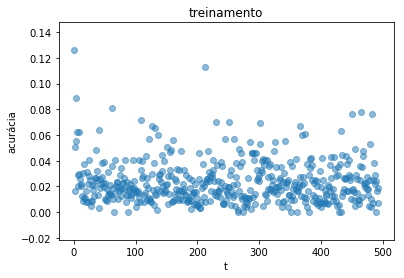

In [322]:
x = range(len(total_rewards))
y = total_rewards
plt.scatter(x, y, alpha=0.5)
plt.title(u'treinamento')
plt.xlabel('t')
plt.ylabel(u'acurácia')
plt.show()

In [323]:
total_rewards = []
algo.epsilon = 0

for user, solutions in groupby(testing_solutions, lambda x: x.user):
    solutions = [s.problem for s in solutions]
    
    total_rewards.append(
        test_algorithm(algo, solutions)
    )

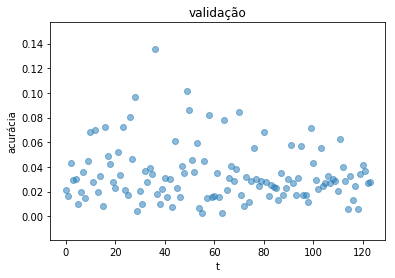

In [324]:
x = range(len(total_rewards))
y = total_rewards
plt.scatter(x, y, alpha=0.5)
plt.title(u'validação')
plt.xlabel('t')
plt.ylabel(u'acurácia')
plt.show()